In [75]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import time
import textwrap
import pickle
import scipy.stats as stats
import xgboost as xgb
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from scipy import spatial
from textblob import TextBlob, Word, Blobber
from scipy import spatial
from textblob import TextBlob, Word, Blobber
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import utils
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, precision_score, roc_curve,auc, recall_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import multiprocessing
cores = multiprocessing.cpu_count()

fontname = 'Montserrat-Regular.ttf'
from matplotlib import font_manager as fm

## Notebook to determine the best doc2vec algorithm to use on script data

In [4]:
def cleanText(text):
    """
    Cleans text for doc2vec
    """
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.lower()
    text = text.replace('x', '')
    return text

In [8]:
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [14]:
def get_feature_vector(train_tagged, test_tagged, dm):
    """
    Build model and vocabulary
    """
    if dm == 'dbow':
        model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
        model.build_vocab([x for x in tqdm(train_tagged.values)])
    elif dm == 'dmm':
        model = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)
        model.build_vocab([x for x in tqdm(train_tagged.values)])  
    """
    Train model
    """
    for epoch in range(30):
        model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
    """
    Build feature vectors
    """
    y_train, X_train = vec_for_learning(model, train_tagged)
    y_test, X_test = vec_for_learning(model, test_tagged)
    """
    Return feature vectors
    """
    return X_train, X_test, y_train, y_test, model

Read in data and clean.

In [2]:
data = pd.read_csv('cleaned_moviedataset.csv')

data = data[['Scripts','new_genres']]
data.columns = ['Scripts','Genres']

In [5]:
data.Scripts = data.Scripts.apply(cleanText)

Split into test and train.

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.Genres)
train_index = pd.Series(train.index)
test_index = pd.Series(test.index)

Tag test and train data to feed into doc2vec, using both DM and DBOW algorithms.

In [9]:
train_tagged_scripts = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Scripts']), tags=[r.Genres]), axis=1)
test_tagged_scripts = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Scripts']), tags=[r.Genres]), axis=1)

Get vectors for train and test data.

In [15]:
X_train_scripts_dbow,X_test_scripts_dbow,y_train_scripts_dbow,y_test_scripts_dbow,model_scripts_dbow = get_feature_vector(train_tagged_scripts, test_tagged_scripts, "dbow")

X_train_scripts_dmm,X_test_scripts_dmm,y_train_scripts_dmm,y_test_scripts_dmm, model_scripts_dmm = get_feature_vector(train_tagged_scripts, test_tagged_scripts, "dmm")


100%|██████████| 2640/2640 [00:00<00:00, 2276981.81it/s]


In [ ]:
"""
with open('X_train_scripts_dbow.pickle', 'wb') as f:
    pickle.dump(X_train_scripts_dbow, f)
with open('X_test_scripts_dbow.pickle', 'wb') as f:
    pickle.dump(X_test_scripts_dbow, f)
with open('y_train_scripts_dbow.pickle', 'wb') as f:
    pickle.dump(y_train_scripts_dbow, f)
with open('y_test_scripts_dbow.pickle', 'wb') as f:
    pickle.dump(y_test_scripts_dbow, f)
with open('X_train_scripts_dmm.pickle', 'wb') as f:
    pickle.dump(X_train_scripts_dmm, f)
with open('X_test_scripts_dbow.pickle', 'wb') as f:
    pickle.dump(X_test_scripts_dmm, f)
with open('y_train_scripts_dmm.pickle', 'wb') as f:
    pickle.dump(y_train_scripts_dmm, f)
with open('y_test_scripts_dmm.pickle', 'wb') as f:
    pickle.dump(y_test_scripts_dmm, f)"""

In [12]:
X_train_scripts_dbow = pickle.load(open("X_train_scripts_dbow.pickle", "rb"))
X_test_scripts_dbow = pickle.load(open("X_test_scripts_dbow.pickle", "rb"))
y_train_scripts_dbow = pickle.load(open("y_train_scripts_dbow.pickle", "rb"))
y_test_scripts_dbow = pickle.load(open("y_test_scripts_dbow.pickle", "rb"))

X_train_scripts_dmm = pickle.load(open("X_train_scripts_dmm.pickle", "rb"))
X_test_scripts_dmm = pickle.load(open("X_test_scripts_dmm.pickle", "rb"))
y_train_scripts_dmm = pickle.load(open("y_train_scripts_dmm.pickle", "rb"))
y_test_scripts_dmm = pickle.load(open("y_test_scripts_dmm.pickle", "rb"))

CV with DBOW

In [32]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cv_results = []

X_train = np.array(X_train_scripts_dbow)
y_train = np.array(y_train_scripts_dbow)

models = {'Random Forest': RandomForestClassifier(),
         'SGD': SGDClassifier(),
         'Naive Bayes': GaussianNB()}

for model_name, model in models.items():
    for train_ind,val_ind in kf.split(X_train,y_train):
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        cv_results.append([model_name,f1])

dbow_cv_df = pd.DataFrame(cv_results)
dbow_cv_df.columns = ['model','f1']

dbow_model_grid_mean_f1 = dbow_cv_df.groupby(['model']).mean()
dbow_model_grid_mean_f1.columns=['DBOW_f1']
dbow_model_grid_f1_var = dbow_cv_df.groupby(['model']).var()
dbow_model_grid_f1_var.columns=['f1_variance, no SMOTE']

CV with DMM

In [31]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cv_results = []

X_train = np.array(X_train_scripts_dmm)
y_train = np.array(y_train_scripts_dmm)

models = {'Random Forest': RandomForestClassifier(),
         'SGD': SGDClassifier(),
         'Naive Bayes': GaussianNB()}

for model_name, model in models.items():
    for train_ind,val_ind in kf.split(X_train,y_train):
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        cv_results.append([model_name,f1])

dmm_cv_df = pd.DataFrame(cv_results)
dmm_cv_df.columns = ['model','f1']

dmm_model_grid_mean_f1 = dmm_cv_df.groupby(['model']).mean()
dmm_model_grid_mean_f1.columns=['DMM_f1']
dmm_model_grid_f1_var = dmm_cv_df.groupby(['model']).var()
dmm_model_grid_f1_var.columns=['f1_variance, no SMOTE']

In [37]:
dmm_models = pd.DataFrame(dmm_model_grid_mean_f1.to_records())

In [38]:
dbow_models = pd.DataFrame(dbow_model_grid_mean_f1.to_records())

Evaluate results to determine best algorithm.

In [53]:
model_results = pd.merge(dmm_models,dbow_models,on='model')
model_results = (model_results.set_index('model'))

In [56]:
model_results

,DMM_f1,DBOW_f1
model,,
Naive Bayes,0.934587,0.055414
Random Forest,0.853973,0.146217
SGD,0.967678,0.126421


Grouped bar plot to compare DMM v DBOW

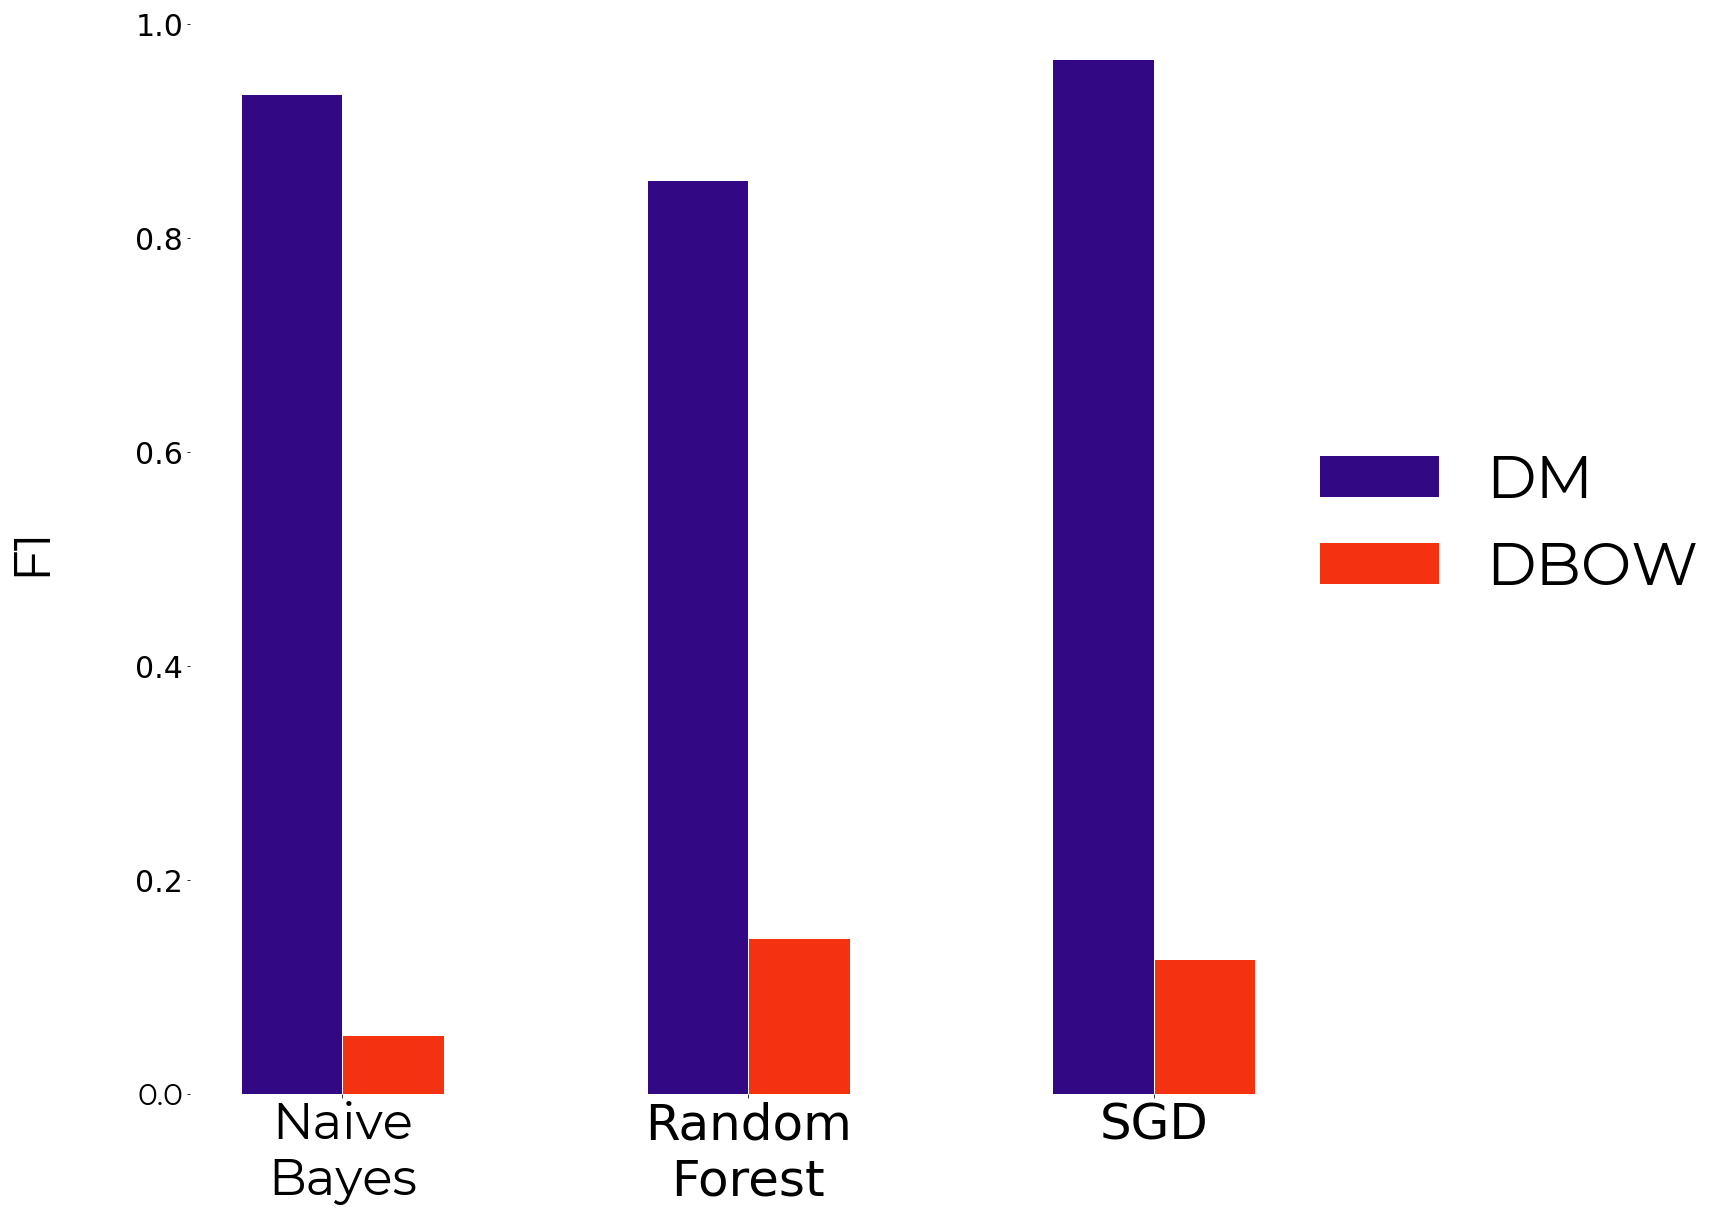

In [156]:
prop = fm.FontProperties(fname=fontname, size=60)

plt.figure(figsize=[20,20])
plt.tight_layout()
barWidth = 0.25
bars1 = model_results.DMM_f1
bars2 = model_results.DBOW_f1

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#330884', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#f43212', width=barWidth, edgecolor='white', label='var2')

plt.yticks(fontproperties=prop, size=30)
plt.ylabel("F1",fontsize=40,fontproperties=prop, size=50, labelpad=80)
#h.set_rotation(0)
plt.box(False)
plt.xticks([(r + barWidth/2) for r in range(len(bars1))], ['Naive\nBayes', 'Random\nForest', 'SGD'], size=50,fontproperties=prop);
legendlabels = ['DM','DBOW']
plt.legend(labels=legendlabels,prop=prop, loc='upper right', fontsize=50, frameon=False,bbox_to_anchor=[1.4, .64]),

plt.savefig('fig_dmm_v_dbow.png',transparent=True,dpi=240, bbox_inches = "tight")